In [2]:
from __future__ import annotations

import itertools
from pathlib import Path
import random
import string
from scipy.signal import welch
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from fooof import FOOOF

from spk2extract.logs import logger
from spk2extract.extraction.oscillations import LfpSignal, get_data

from scipy.signal import coherence
# Setup functions, classes and styles
logger.setLevel("INFO")
sns.set_style("darkgrid")

data_path = Path().home() / "data" / "extracted" / "dk1"
file = list(data_path.glob("*dk1*.h5"))[0]
df_s, df_t, events, event_times = get_data(file)
unique_events = np.unique(events)
key = {
    "0": "dug incorrectly",
    "1": "dug correctly",
    "x": "crossed over (no context)",
    "b": "crossed over into the black room",
    "w": "crossed over into the white room",
}
fs = 2000
lfp = LfpSignal(df_s, df_t, event_arr=events, ev_times_arr=event_times, fs=2000, filename=file,
                exclude=["LFP1_AON", "LFP2_AON"])



/home/flynn/conda/envs/spk2extract/lib/python3.9/site-packages/fooof/plts/utils.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, ax = plt.subplots(figsize=figsize)


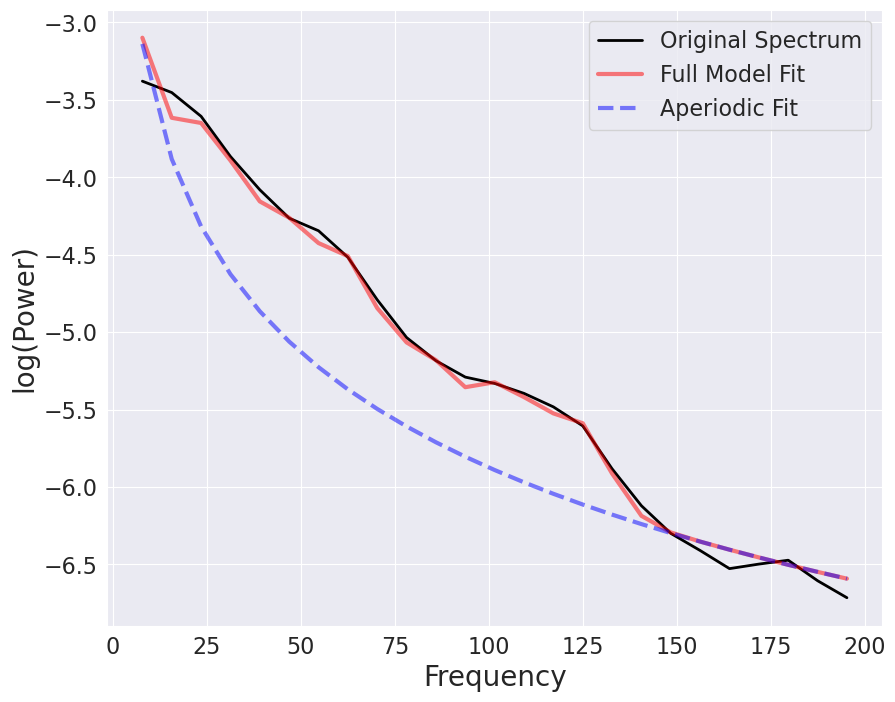

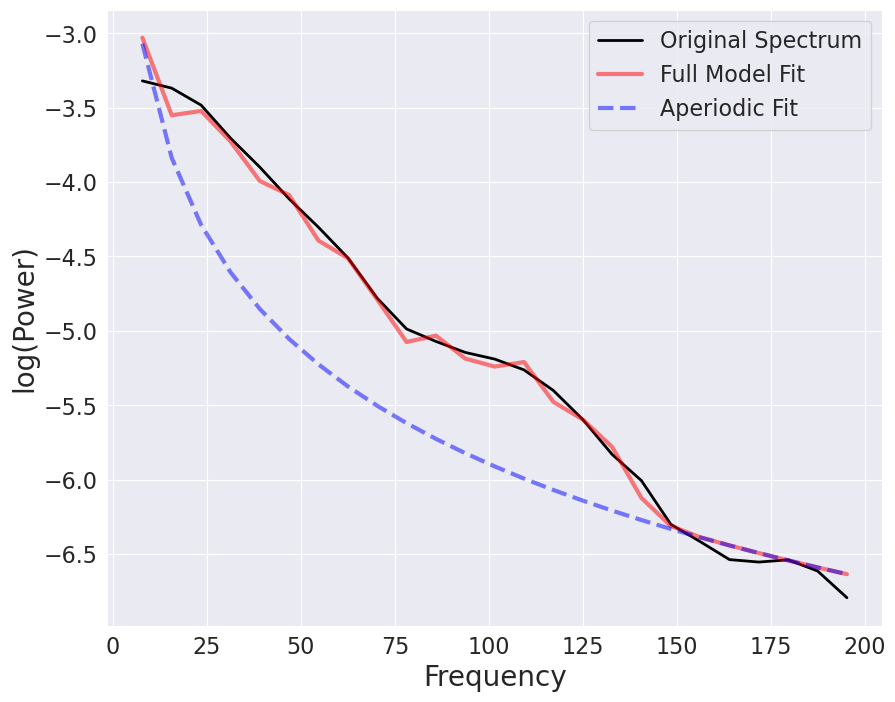

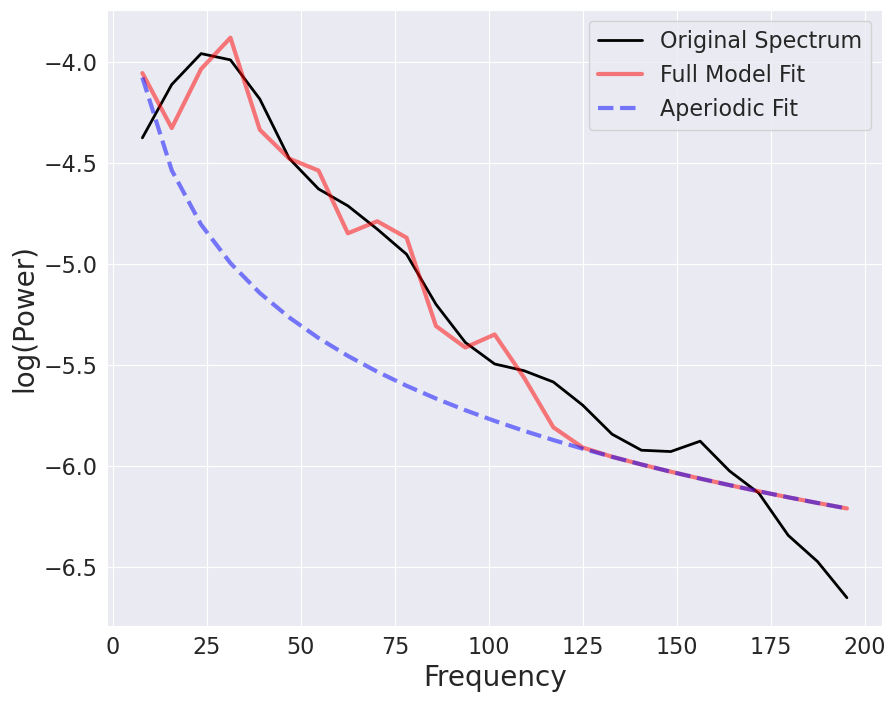

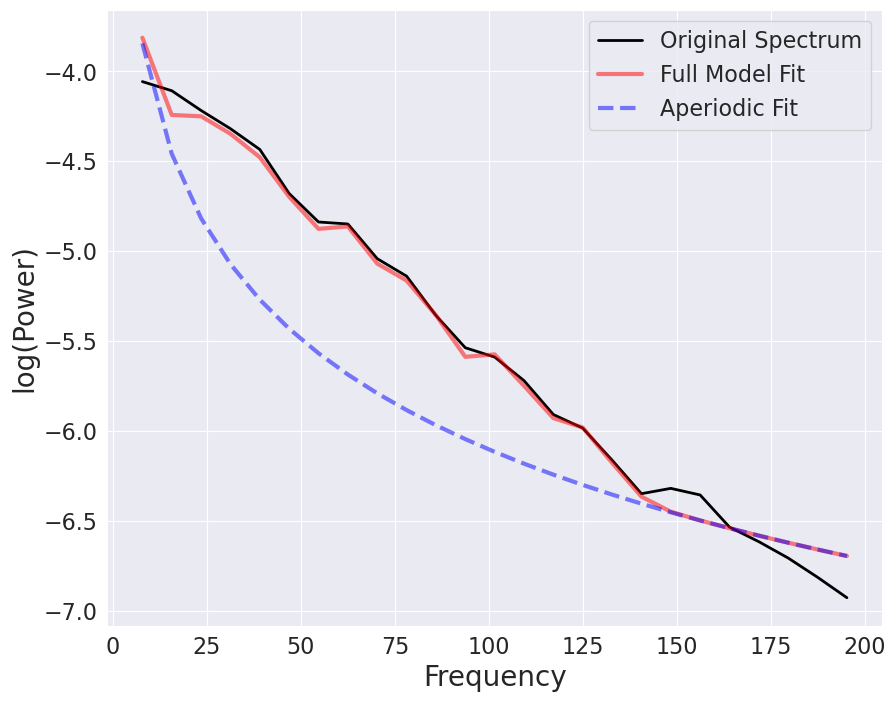

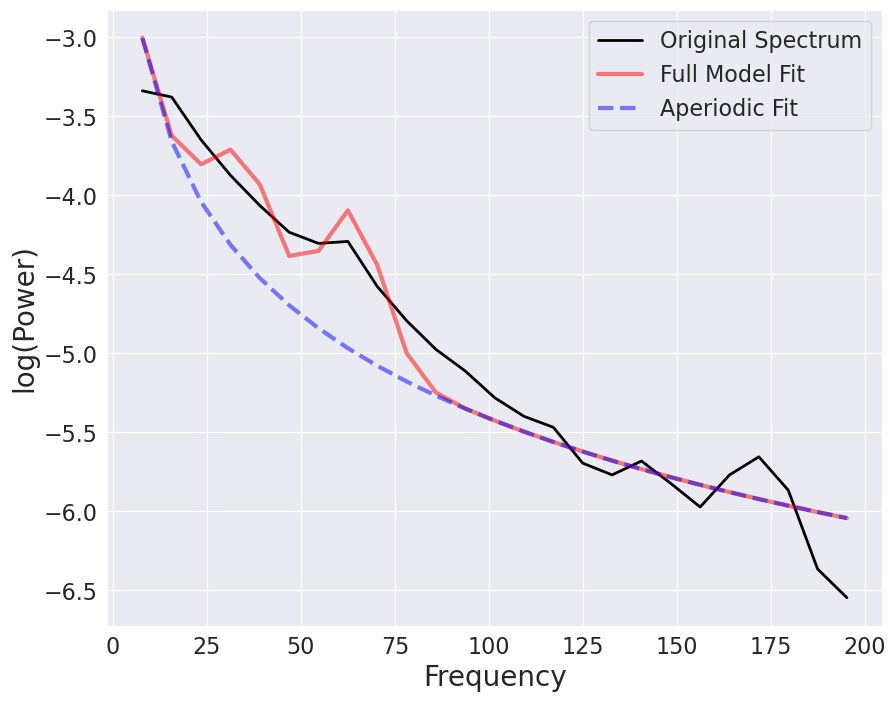

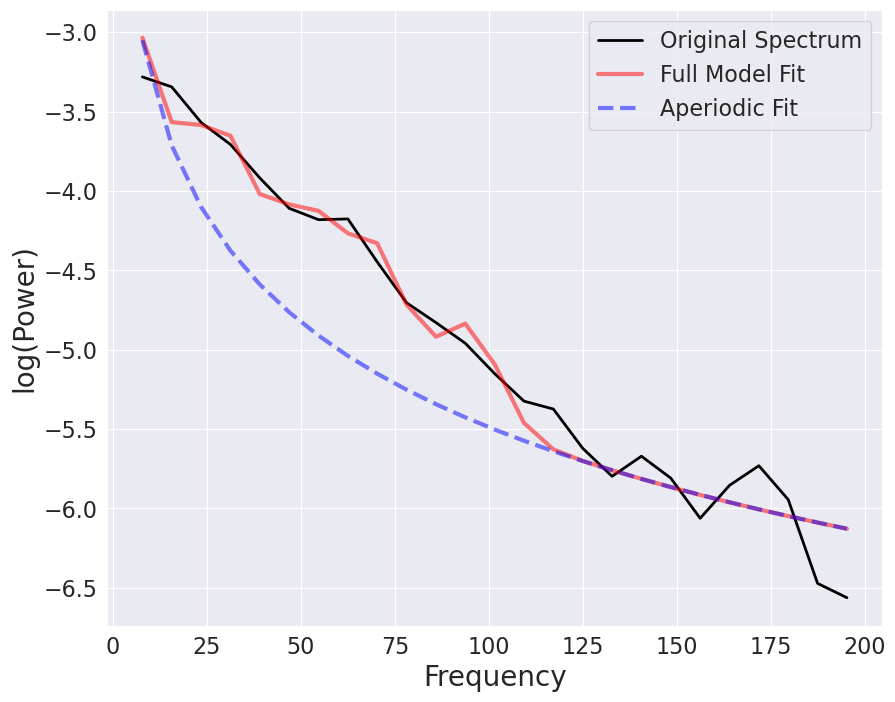

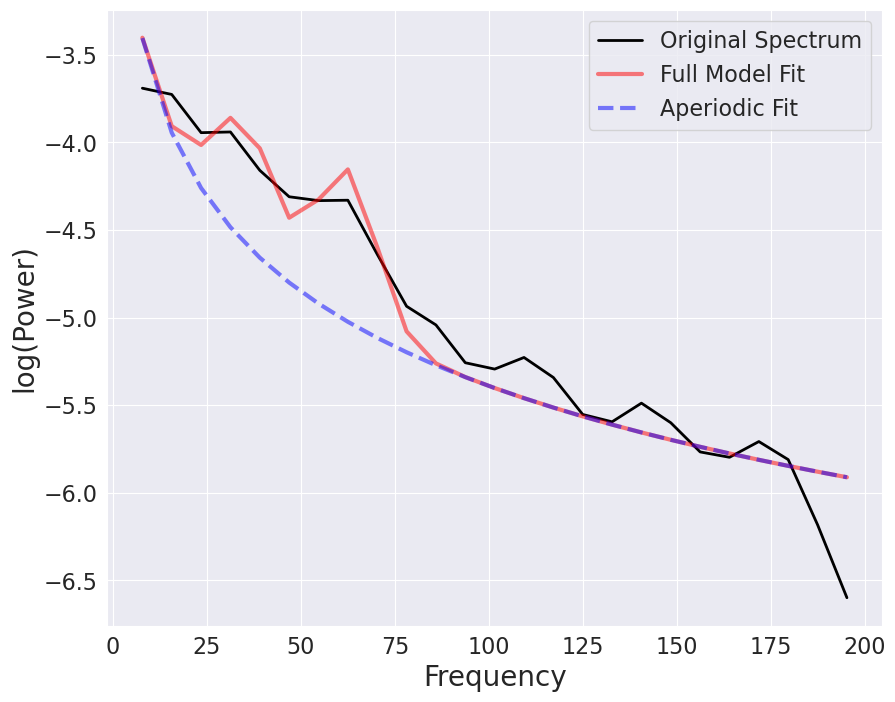

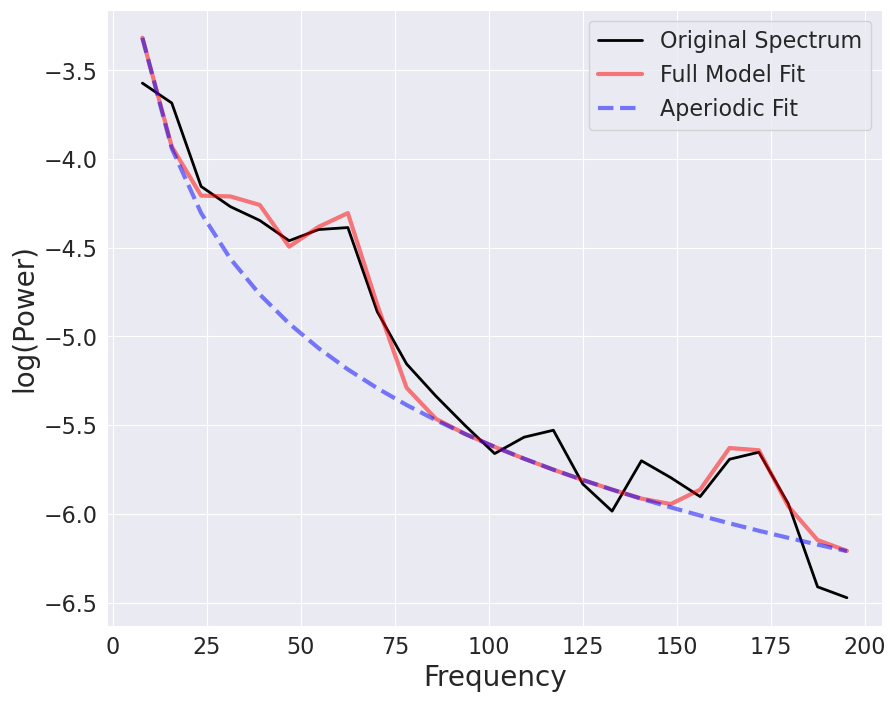

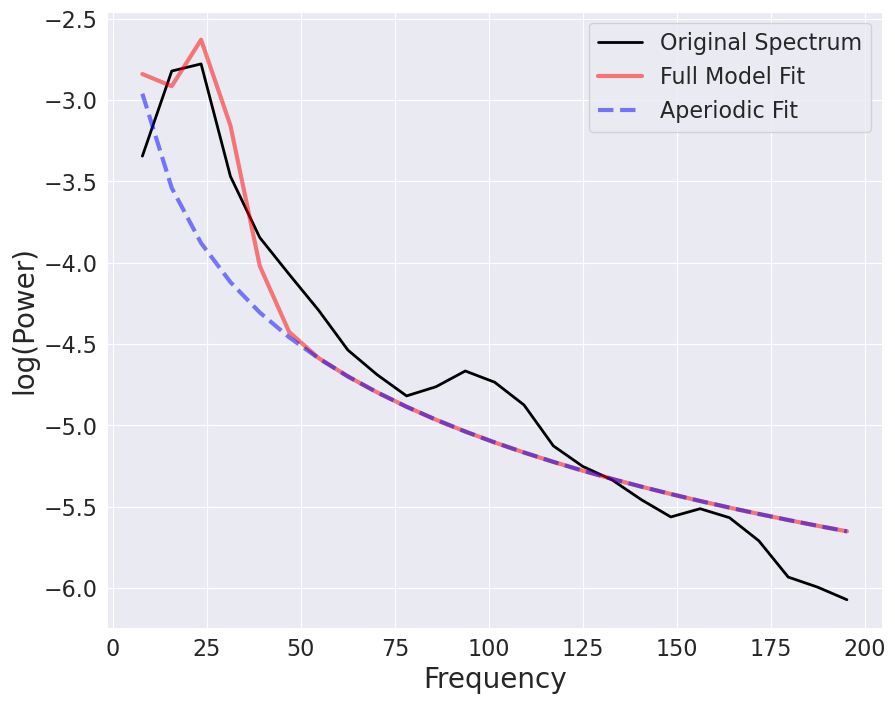

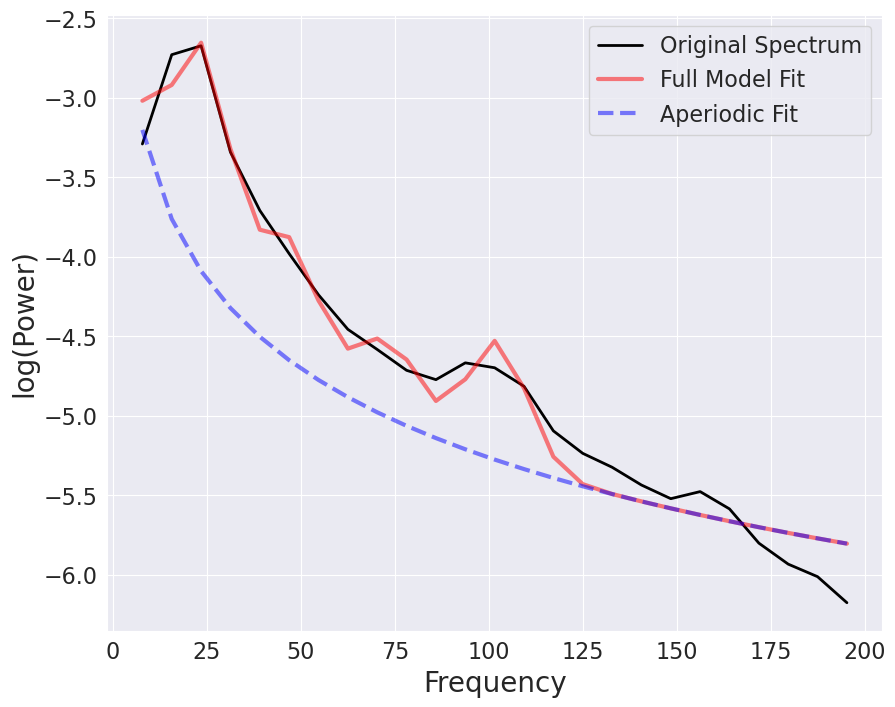

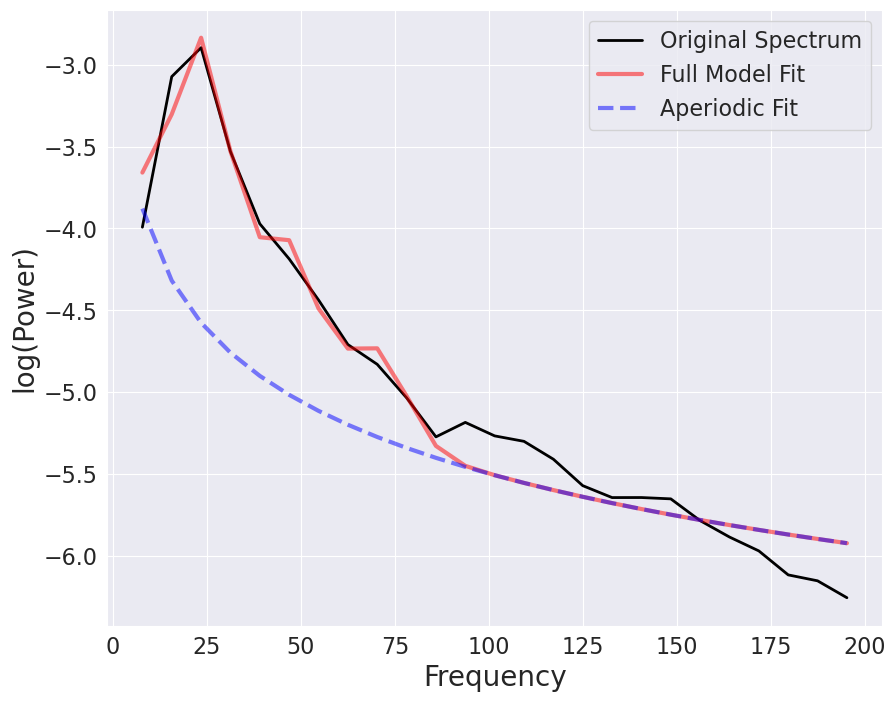

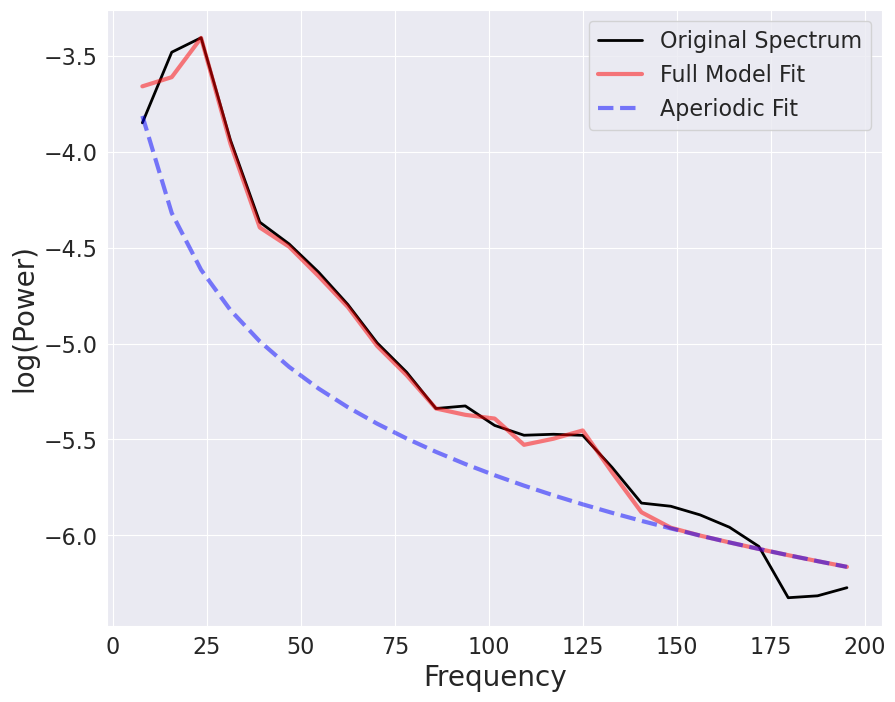

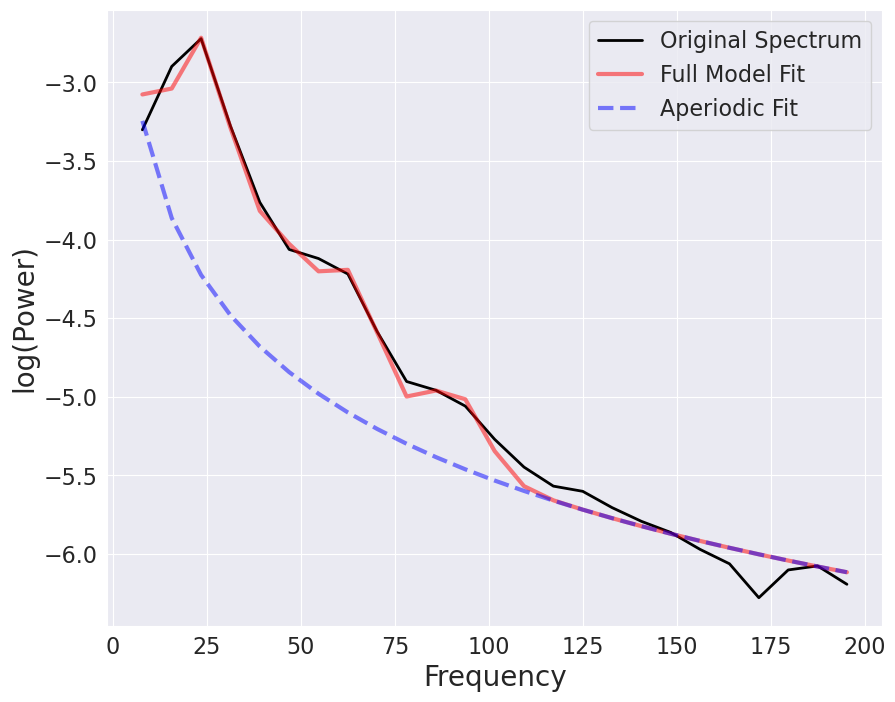

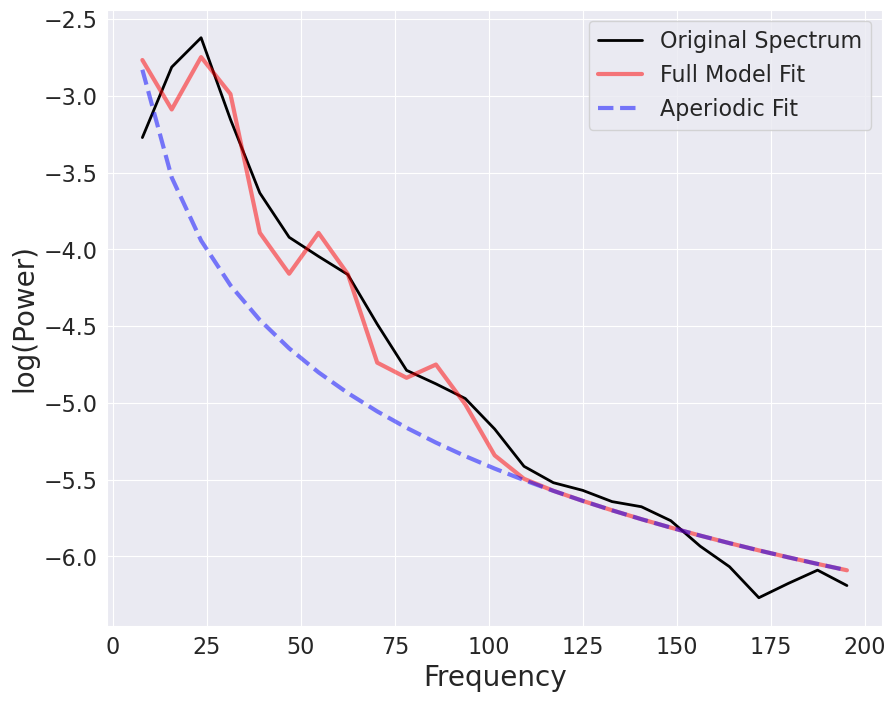

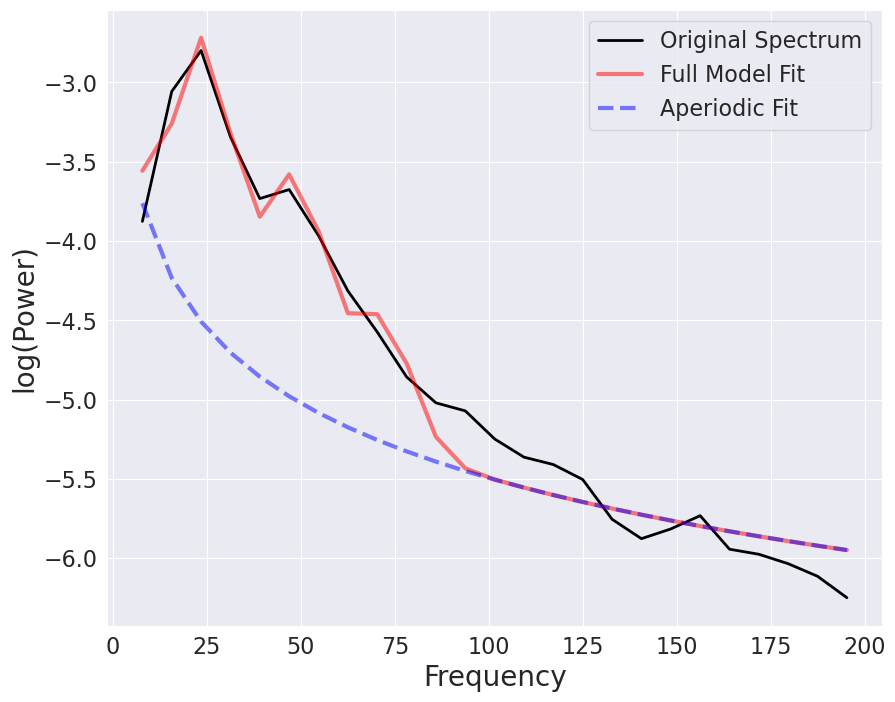

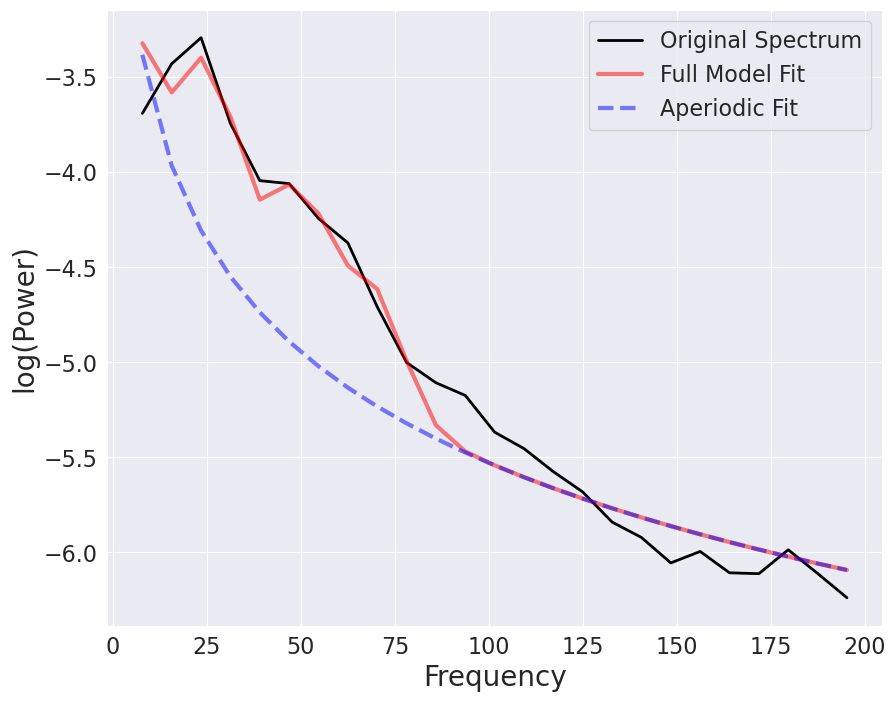

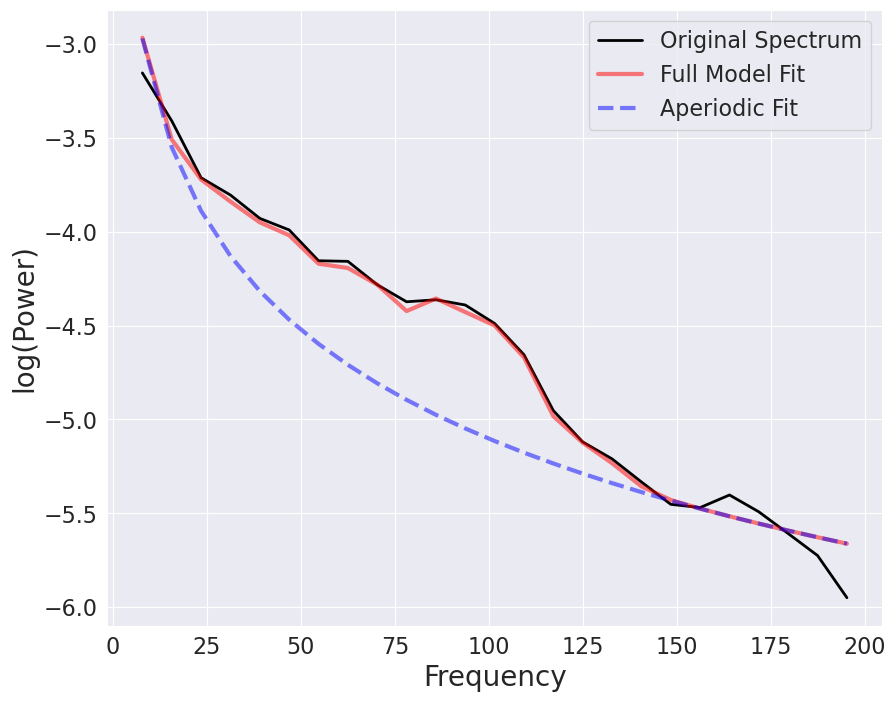

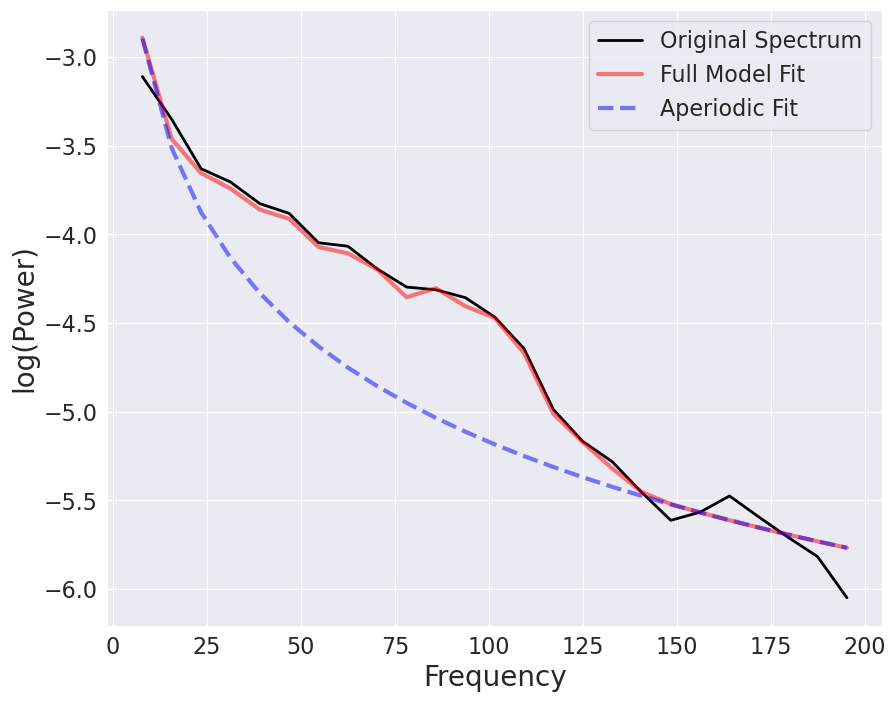

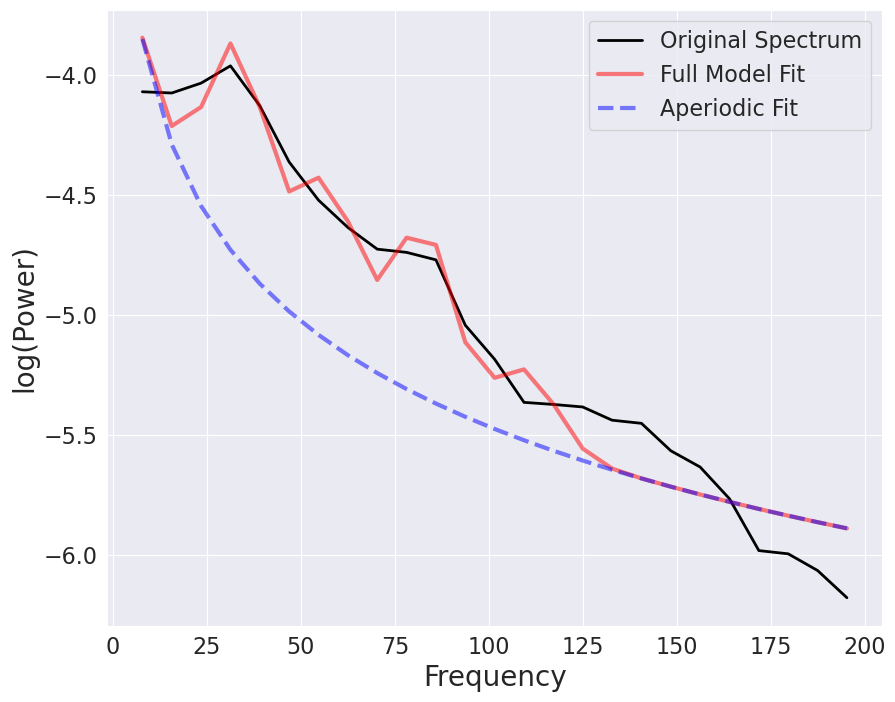

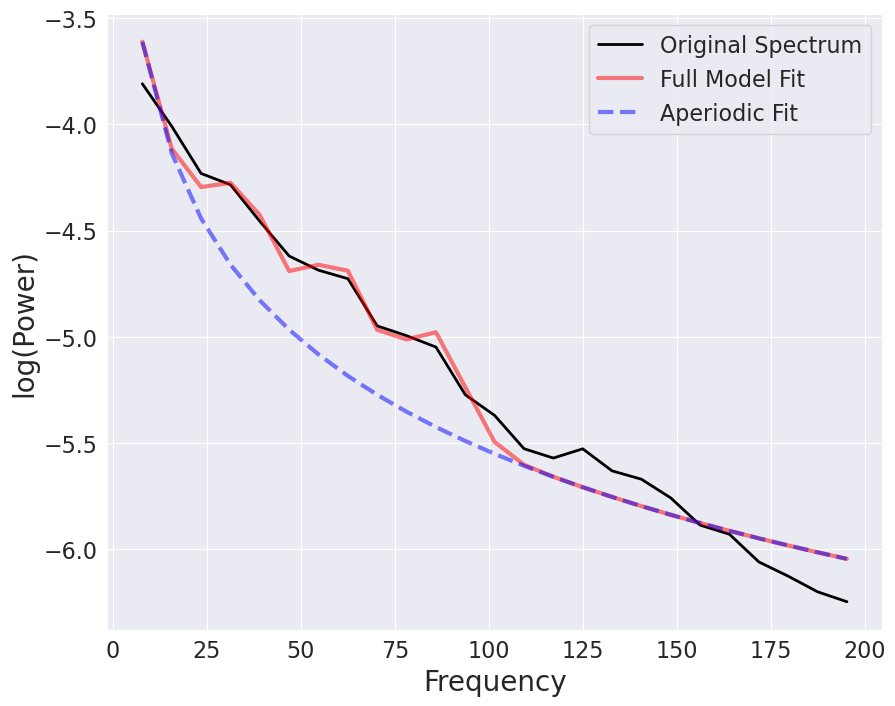

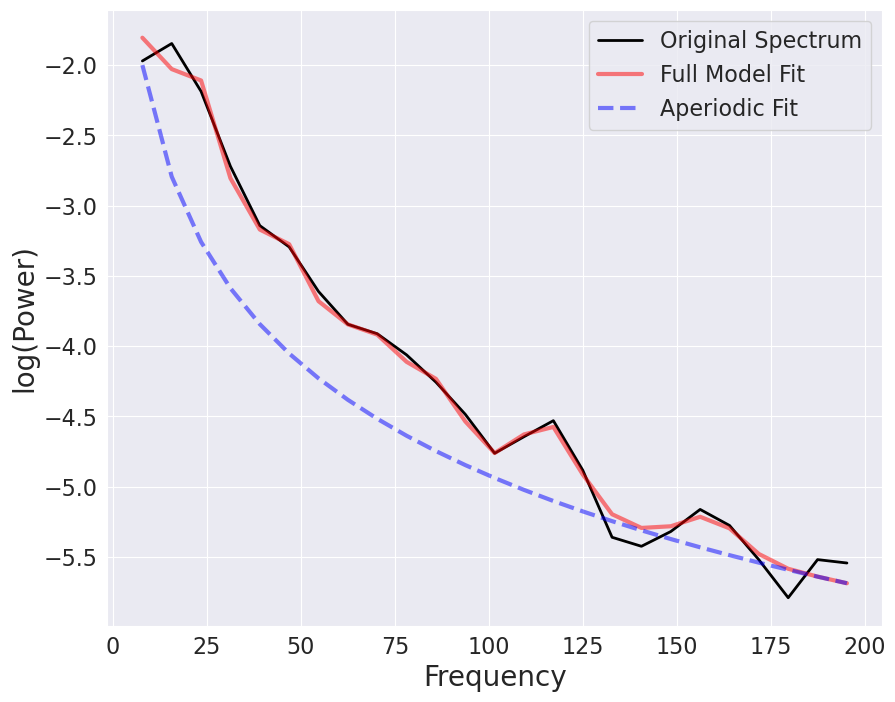

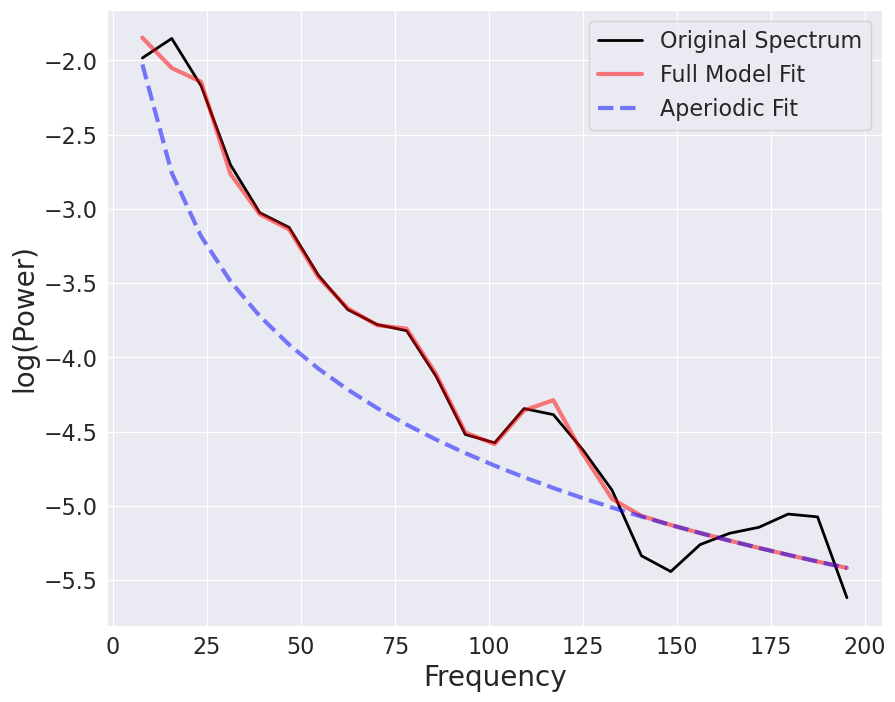

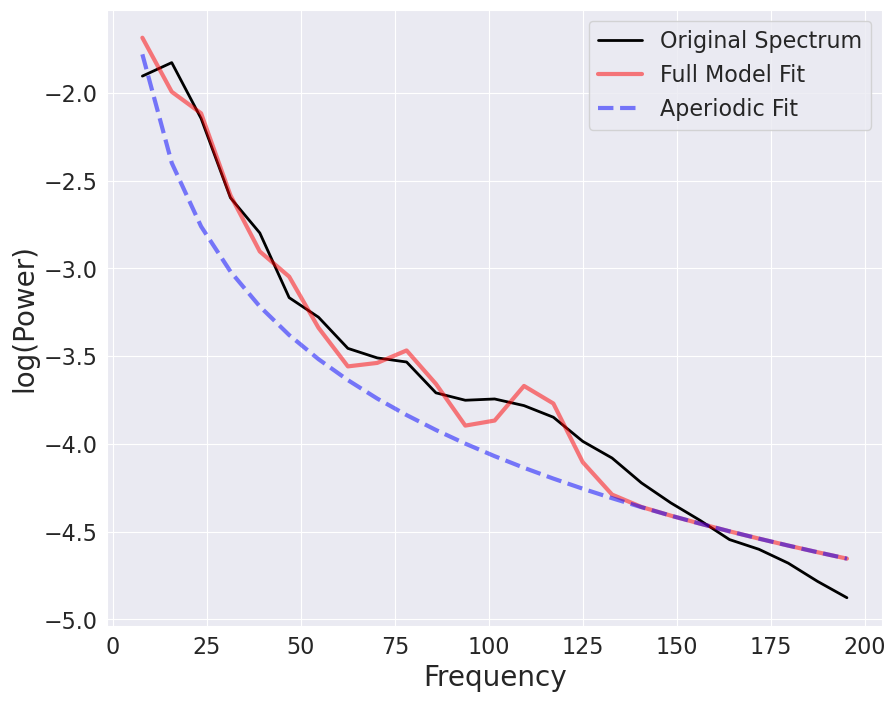

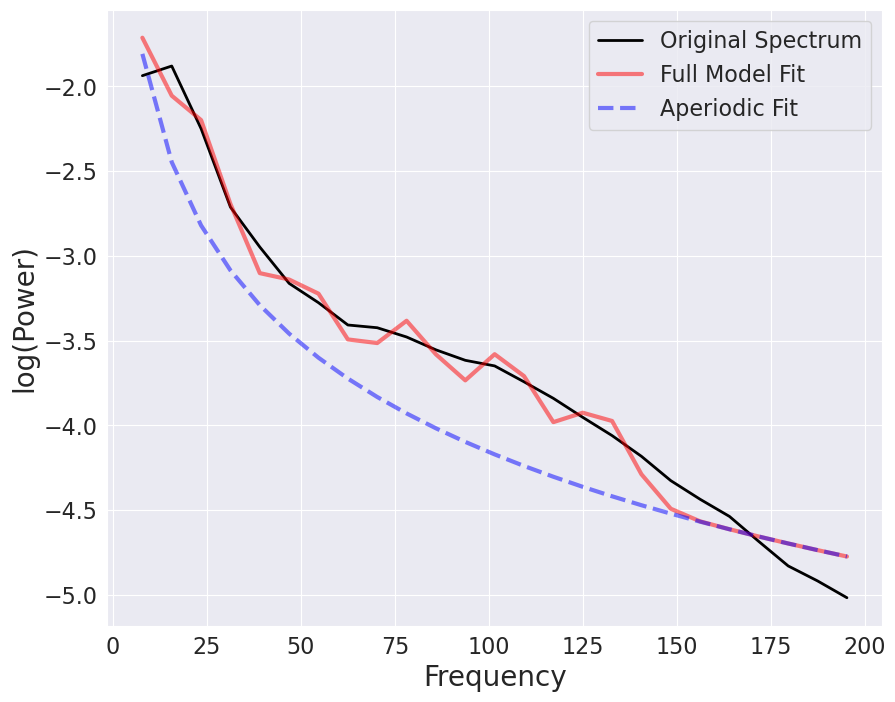

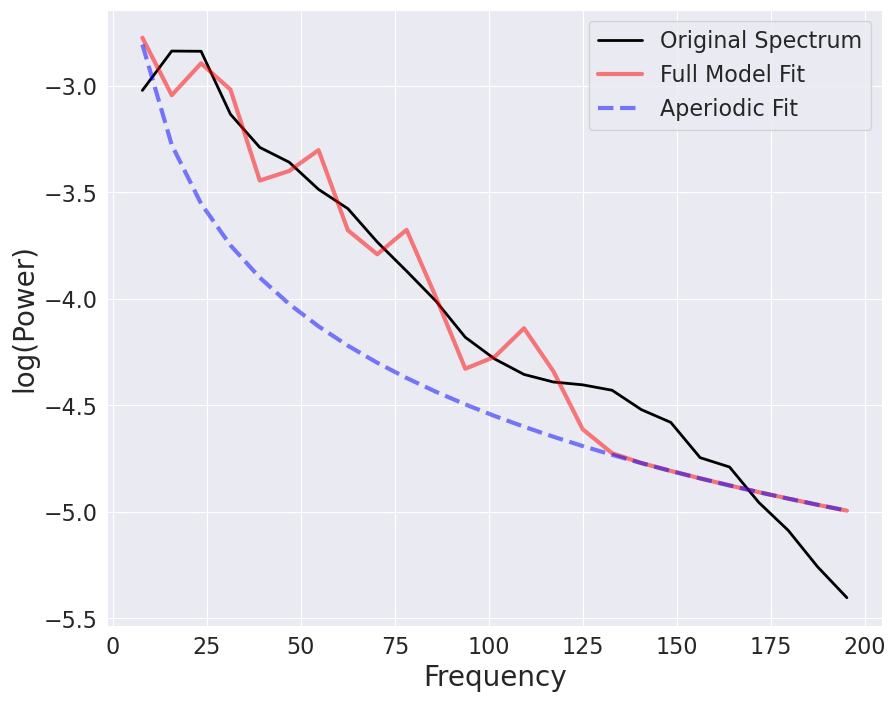

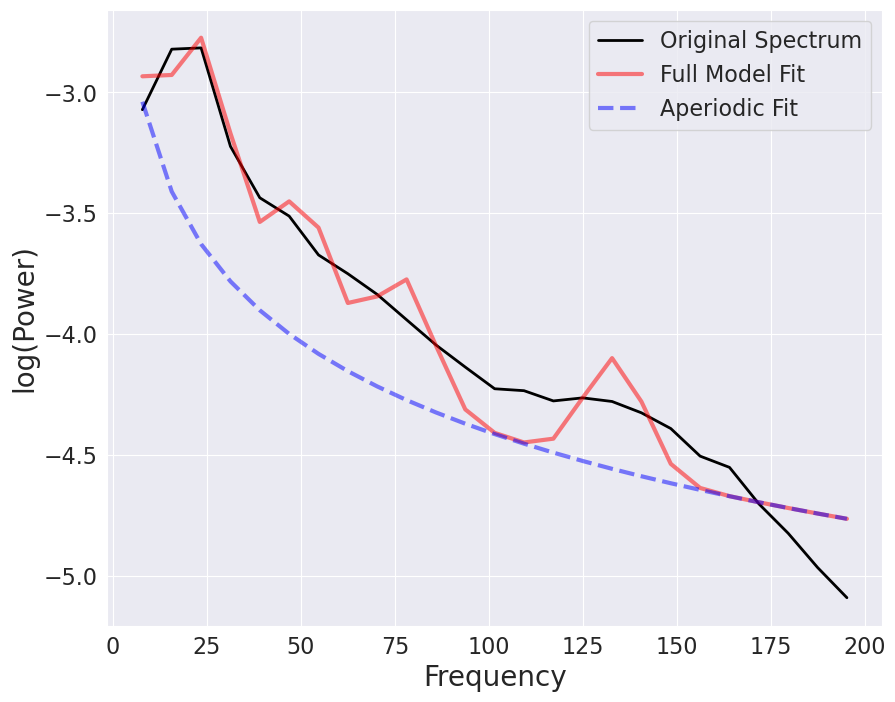

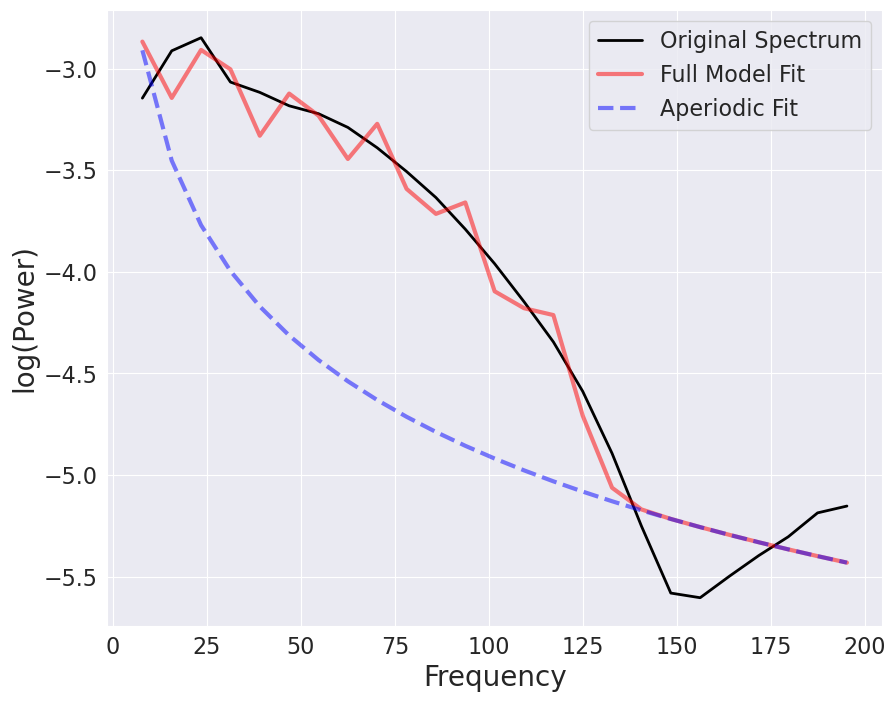

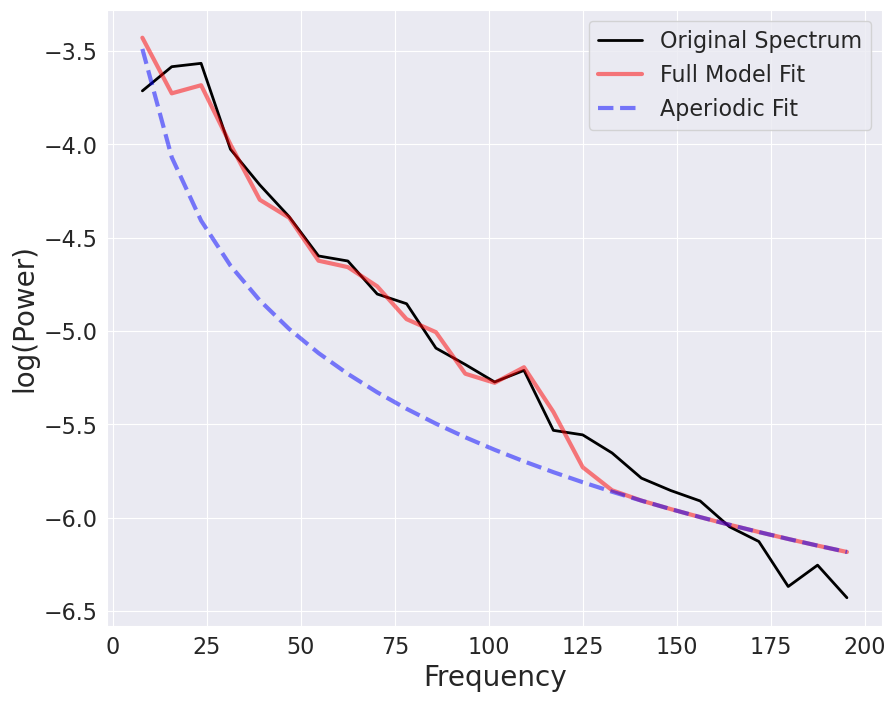

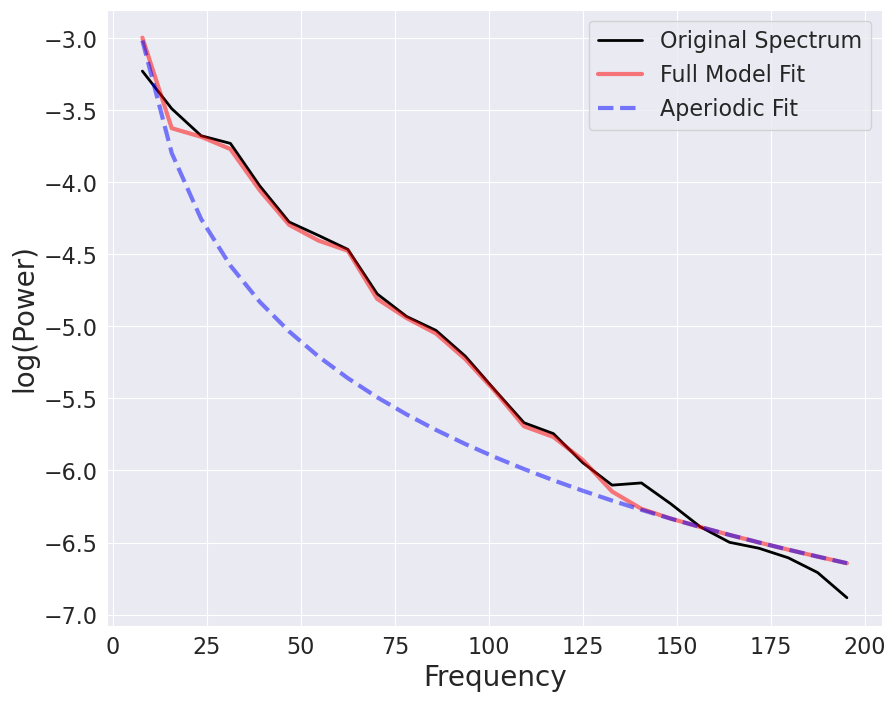

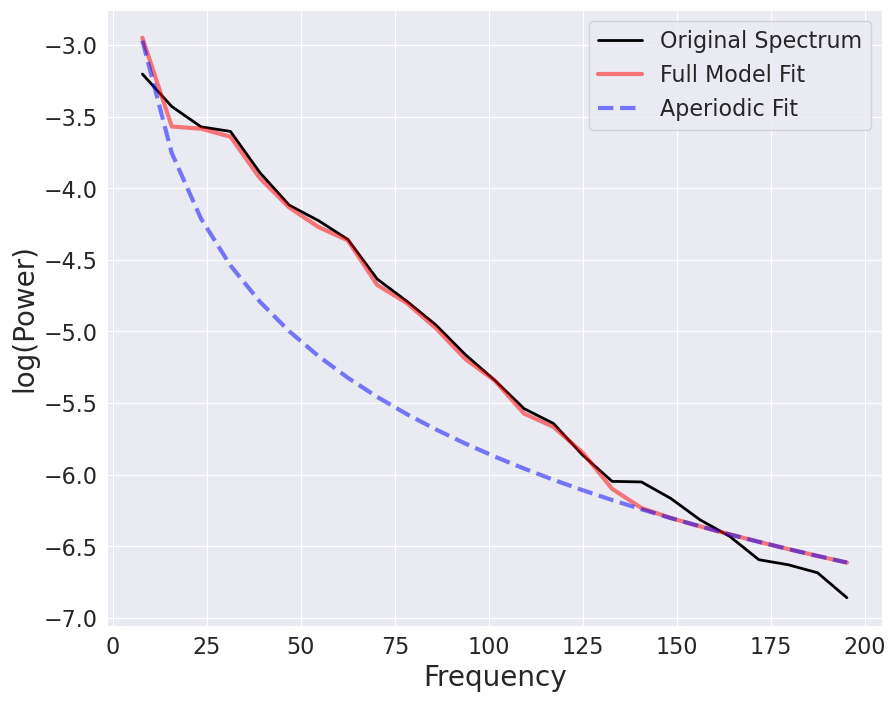

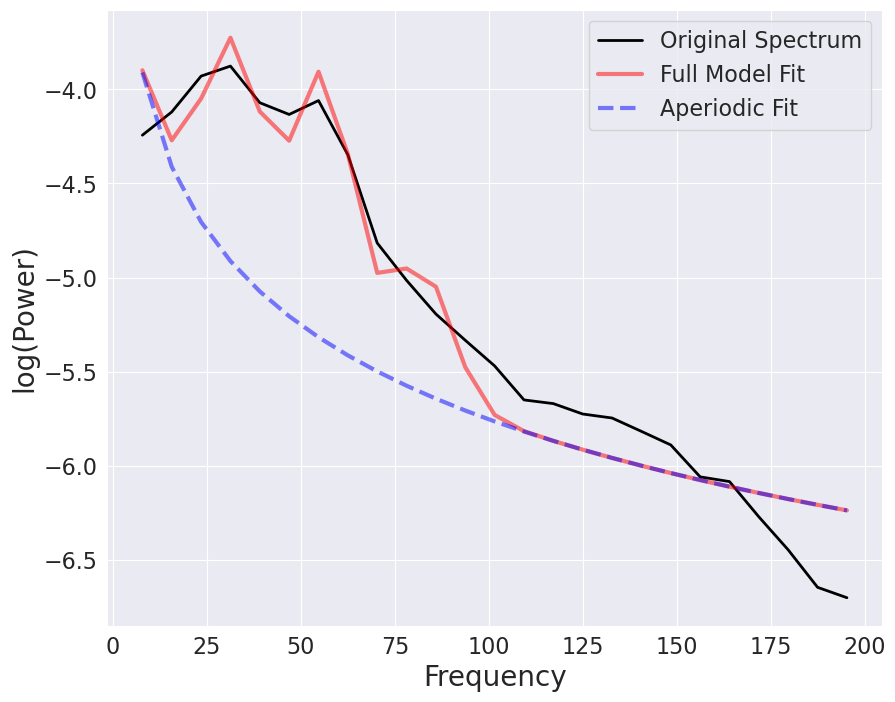

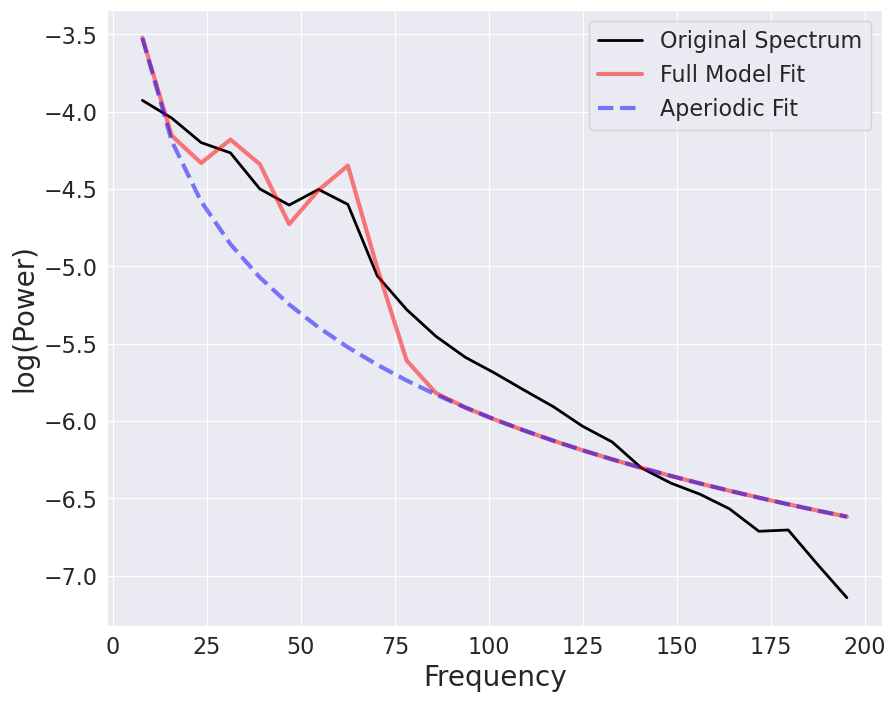

In [4]:

freqs = lfp.fft_data
fooof_models = {}
window_dict = lfp.get_windows(3)
spikes = lfp.spikes

for name, windows in window_dict.items():
    for window in windows:
        window_idx = [x * fs for x in window]
        random_string = ''.join(random.choices(string.ascii_uppercase + string.digits, k=10))
        for channel in lfp.spikes.columns:
            lfp_signal = spikes.loc[window_idx[0]:window_idx[1], channel].values

            # Compute the Power Spectral Density (PSD)
            frequencies, psd_values = welch(lfp_signal, fs=lfp.fs)

            # Slice frequencies and PSD values for 1-50Hz
            idx_start = np.where(frequencies >= 1)[0][0]
            idx_end = np.where(frequencies <= 200)[0][-1]
            frequencies = frequencies[idx_start:idx_end+1]
            psd_values = psd_values[idx_start:idx_end+1]

            # Calculate peak width limits
            peak_width_limits = [2 * (frequencies[1] - frequencies[0]), 16]

            # Initialize FOOOF model
            fm = FOOOF(peak_width_limits=peak_width_limits)

            # Fit FOOOF model
            fm.fit(frequencies, psd_values)
            fooof_models[random_string] = fm

            # Plot
            fm.plot()
